# 네이버 웹 크롤링 - 코로나 현황

### 1. 필요한 모듈 로드해오기

In [2]:
import pymysql as mysql
import pandas as pd
import platform 
import folium
import matplotlib.pyplot as plt
from selenium import webdriver
from matplotlib import font_manager, rc
from bs4 import BeautifulSoup

In [3]:
if platform.system() == 'Windows': 
    path = 'c:/Windows/Fonts/malgun.ttf'
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
elif platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
else: 
    print('Check your OS system')

### 2. MySQL 설정 해주기

<p> 이번 프로젝트를 위한 새로운 DB 설정과 이용할 유저를 미리 만들어 두었습니다.
</p>

In [4]:
conn = mysql.connect(   
    host='localhost',
    user='ssac_ysh',
    password='YSH!23',
    db='covid19status',
    port=3307,
    charset='utf8'
) 

#### 2.1 필요한 MySQL 함수 만들어주기

<p> 누적 데이터를 테이블에 추가하는 함수</p>

In [5]:
def insertIntoTotalData(data):
    cur = conn.cursor()
    sql = """INSERT 
                INTO total_confirmed_cases ( city, n_confirmed_case ) 
                VALUES ( %s, %s )"""

    for covid_data in data:
        cur.execute(sql,(covid_data[0], covid_data[1].replace(',', '')))

    conn.commit()

<p> 일별 데이터를 테이블에 추가하는 함수</p>

In [39]:
def insertIntoDailyData(data):
    cur = conn.cursor()
    sql = """INSERT 
                INTO daily_confirmed_cases ( dt, n_domestic, n_international ) 
                VALUES ( %s, %s, %s )"""

    cur.execute(sql,(data[0],                        # date
                     data[1].replace(',', ''),       # domestic
                     data[2].replace(',', '')))      # international
    conn.commit()

<p> 일별 데이터를 가져오는 함수</p>

In [46]:
def fetchDailyData():
    cur = conn.cursor()
    sql = \
        """ SELECT
                    dt
                ,   n_domestic
                ,   n_international
            FROM daily_confirmed_cases
        """
    
    cur.execute(sql)
    
    result = cur.fetchall()
        
    return result

<p> 누적 데이터를 가져오는 함수</p>

In [8]:
def fetchTotalData():
    cur = conn.cursor()
    sql = \
        """ SELECT
                    city
                ,   n_confirmed_case
            FROM total_confirmed_cases
        """
    
    cur.execute(sql)
    
    result = cur.fetchall()
        
    return result

<p> 실행하기전 쌓여있는 데이터를 정리해주는 함수</p>

In [9]:
def cleanTables():
    cur = conn.cursor()
    truncate1 = """TRUNCATE daily_confirmed_cases"""
    truncate2 = """TRUNCATE total_confirmed_cases"""
    cur.execute(truncate1)
    cur.execute(truncate2)

    conn.commit()

<p> 데이터베이스의 활용을 끝냈다면 커넥션을 끊어주는 함수</p>

In [10]:
def closeConnection():
    conn.close()

### 데이터 정리 

In [44]:
cleanTables()

### 3. 웹 크롤링

In [12]:
driver = webdriver.Chrome('C:/ProgramData/Anaconda/envs/playdata/crawling/chromedriver.exe')
url = 'https://search.naver.com/search.naver?sm=tab_hty.top&where=nexearch&query=%EC%BD%94%EB%A1%9C%EB%82%98+%ED%98%84%ED%99%A9&oquery=%EC%BD%94%EB%A1%9C%EB%82%98+%ED%98%84%ED%99%A9&tqi=hfkY0wp0Jy0ssiQ97E8ssssstiR-146897'

driver.get( url )

#### 3.1 일별 확진자 수 구하기

In [19]:
html = driver.page_source

soup = BeautifulSoup(html, 'html.parser')





In [45]:
html = driver.page_source

soup = BeautifulSoup(html, 'html.parser')
# data_chart = soup.select('#target2 .column')

for idx in range(1, 7):
    data_bar = driver.find_element_by_xpath('//*[@id="target2"]/dl/div[{}]/dd[1]'.format(idx))
    data_bar.click()
    date_raw = driver.find_element_by_class_name('_x_value').text.split('.')
    date = '2021-{}-{}'.format(
                        date_raw[0].zfill(2), 
                        date_raw[1].zfill(2))
    domestic = driver.find_element_by_class_name('_y_first_value').text
    international = driver.find_element_by_class_name('_y_second_value').text
    
    insertIntoDailyData([date,domestic,international])   

In [54]:
res = fetchDailyData()

daily_covid_dates  = []
daily_covid_cnfmed_domestic = []
daily_covid_cnfmed_international = []

for row in res:
    daily_covid_dates.append( '{}.{}'.format(row[0].month, 
                                             row[0].day))  # date
    daily_covid_cnfmed_domestic.append(row[1])             # domestic count
    daily_covid_cnfmed_international.append(row[2])        # international count


daily_df = pd.DataFrame({'Date':daily_covid_dates,
                         'International':daily_covid_cnfmed_international,
                         'Domestic':daily_covid_cnfmed_domestic
                        }).set_index( 'Date' )

daily_df

,International,Domestic
Date,,
8.19,51,1999
8.20,66,1811
8.21,38,1588
8.22,48,1369
8.23,39,1468
8.24,41,2113


#### 3.2 누적 확진자 수 구하기

In [61]:
total_cases_button = driver.find_element_by_xpath( '*//span[@class="menu" and text()="지역별 표"]')
total_cases_button.click()

In [62]:
html = driver.page_source
soup = BeautifulSoup(html, 'html.parser')

total_confirmed_cases = []
total_data = soup.select( '.type_basic > .table' )
total_pages = 3

for page in range( total_pages ):
    data  =  total_data[ page ].select( 'tbody tr td' )
    for idx in range( 0, len( data ), 3 ):
        city  = data[idx].select( '.text' )[0].text.strip()
        count = data[idx + 1].select( '.text' )[0].text
        total_confirmed_cases.append( [ city, count ] )
        
insertIntoTotalData( total_confirmed_cases )

In [63]:
res = fetchTotalData()

total_covid_dates = []
total_covid_cnfmed = []

for row in res:
    total_covid_dates.append( row[ 0 ] )  # city
    total_covid_cnfmed.append( row[ 1 ] ) # count


total_df = pd.DataFrame( {'City'  : total_covid_dates,
                          'Count' : total_covid_cnfmed } ).set_index( 'City' )

total_df

,Count
City,
서울,76814
경기,68671
대구,13287
인천,11406
부산,11077
경남,9683
경북,6866
충남,6639
검역,5761


### 4. 시각화

#### 4.1 일별 신규 확진자 그래프

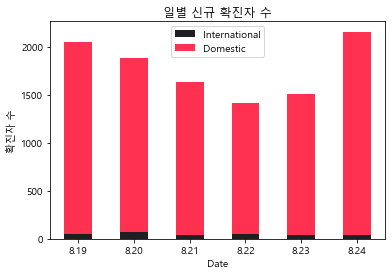

In [60]:
daily_df.plot(
    kind='bar', 
    title='일별 신규 확진자 수',
    rot=0,
    ylabel='확진자 수',
    stacked=True,
    color={"Domestic": "#ff3150", "International": "#1e1e23"}
)

plt.show()

#### 4.2 월별 누적 확진자 그래프

In [64]:
location_df = pd.read_csv('./files/도시별_경위도.csv' )

In [65]:
total_df_no_index = total_df.reset_index()
location_count_df = pd.merge(location_df, total_df_no_index, on='City', how='inner')
location_count_df

,City,Longitute,Latitude,Count
0,서울,37.566898,126.980010,76814
1,경기,37.405622,127.468901,68671
2,대구,35.822827,128.562041,13287
3,인천,37.453605,126.699858,11406
4,부산,35.169882,129.050933,11077
5,경남,35.476662,128.176249,9683
6,경북,36.585049,126.837223,6866
7,충남,34.809693,129.138858,6639
8,검역,36.337646,127.392032,5761
9,대전,37.826501,128.274685,5463


In [68]:
center = ['36.12790033349445', '127.82658973039062'] 
m = folium.Map(location=center, zoom_start=6)

for i in range( len(location_count_df ) ):
    data = location_count_df.iloc[i]
    name = data['City']
    long = float(data['Longitute'])
    lat = float(data['Latitude'])
    size = int(data['Count']) // 1000
    folium.CircleMarker((long,lat), radius = size, color='#957DAD', tooltip=name, fill=True).add_to(m)

m

#### 4.3 지도 저장

In [69]:
m.save('./files/covid19_total_confirmed_cases.html') 

### 5. Close DB Connection

In [70]:
closeConnection()